In [1]:
import cv2
import numpy as np
import skimage
from skimage import filters
from skimage import morphology
import matplotlib.pyplot as plt
from skimage import transform as tf
from skimage.measure import label, find_contours
from skimage.feature import match_template

from dpipe.im.box import mask2bounding_box

In [2]:
def remove_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                             for i in range(gray.ndim)]) / gray.ndim)
    bin_sobel_mag  = sobel_mag > 0.1

    kernel1 = np.ones((3, 3), 'uint8')
    kernel2 = np.ones((7, 7), 'uint8')

    erode_img = bin_sobel_mag.astype('uint8')
    dilate_img = cv2.dilate(erode_img, kernel2, iterations=1)

    _, contours, hierarchy = cv2.findContours(dilate_img.astype('uint8'), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]

    index = np.argmax(areas)

    rect = cv2.minAreaRect(contours[index])

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    distances = [np.linalg.norm(point) for point in box]
    if np.argmin(distances) == 1:
        box = box[[1, 2, 3, 0]]
        
    w = np.sqrt(np.sum((box[1] - box[0])**2))
    h = np.sqrt(np.sum((box[2] - box[1])**2))

    w = int(w)
    h = int(h)

    src = np.array([[0, 0], [0, w], [h, w], [h, 0]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, box)
    result_table = tf.warp(img, tform3, output_shape=(w, h))

    
    return result_table

In [3]:
def filter_boxes(boxes, len_points, th = 0.1):
    final_boxes = []
    
    boxes = np.array(boxes)
    x0 = boxes[:, 1]
    y0 = boxes[:, 0]
    x1 = boxes[:, 3]
    y1 = boxes[:, 2]
    ars = (x1 - x0) * (y1 - y0)

    ids = np.argsort(len_points)
    
    while len(ids) > 0:

        final_boxes.append(boxes[ids[-1]])

        x_1 = np.maximum(x0[ids[-1]], x0[ids[:-1]])
        x_2 = np.minimum(x1[ids[-1]], x1[ids[:-1]])
        y_1 = np.maximum(y0[ids[-1]], y0[ids[:-1]])
        y_2 = np.minimum(y1[ids[-1]], y1[ids[:-1]])

        inter = np.maximum(0.0, x_2 - x_1 + 1) * np.maximum(0.0, y_2 - y_1 + 1)
        iou = inter / (ars[ids[-1]] + ars[ids[:-1]] - inter)
        ids = ids[np.where(iou < th)]

    return final_boxes

In [93]:
def get_box_of_true_pill(new):
    new *= 255
    gray = cv2.cvtColor(new.astype('uint8'), cv2.COLOR_BGR2GRAY)
    sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                                 for i in range(gray.ndim)]) / gray.ndim)
    bin_sobel_mag  = sobel_mag > 0.1
    kernel1 = np.ones((3, 3), 'uint8')
    kernel2 = np.ones((5, 5), 'uint8')
    dilate_img = cv2.dilate(bin_sobel_mag.astype('uint8'), kernel2, iterations=1)


    labeled_mask, count = label(1-dilate_img, return_num=True, connectivity = 2)
    areas = []
    ps = []
    for l in range(1, count + 1):
        component_mask = labeled_mask == l
        areas.append(np.sum(component_mask))

    indexes = np.argsort(areas)[-3:]
#     print(areas)
    
    component_mask = labeled_mask == indexes[0] + 1
    component_mask += labeled_mask == indexes[1] + 1
    component_mask += labeled_mask == indexes[2] + 1
#     plt.imshow(component_mask, 'gray')
#     component_mask += labeled_mask == indexes[3] + 1
#     component_mask += labeled_mask == indexes[4] + 1
    _, contours, hierarchy = cv2.findContours(component_mask.astype('uint8'), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    ps = [cv2.arcLength(cnt, True) for cnt in contours]

    component_mask = labeled_mask == indexes[np.argmin(ps)] + 1
    plt.imshow(component_mask, 'gray')
    
    return mask2bounding_box(component_mask)
    

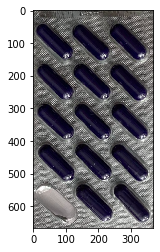

In [107]:
img_path = 'pills/03.jpg'
img = cv2.imread(img_path)
new = remove_edges(img)[20:-20, 20:-20]

plt.imshow(new)


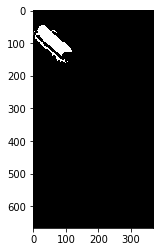

In [108]:
padd = 10
bbox = get_box_of_true_pill(new)

gray = cv2.cvtColor(new.astype('uint8'), cv2.COLOR_BGR2GRAY)

query = gray[bbox[0][0]: bbox[1][0], bbox[0][1]: bbox[1][1]]
gallery = gray.copy()
query = query[padd:-padd, padd:-padd]

result = match_template(gallery, query)

# plt.imshow(result)

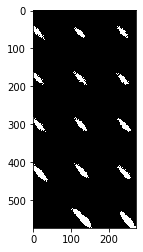

In [109]:
plt.imshow(result > 0.6, 'gray')

In [110]:
res = result > 0.6
shape = res.shape
kernel2 = np.ones((5, 5), 'uint8')
dilate_res = cv2.dilate(res.astype('uint8'), kernel2, iterations=1)
# plt.imshow(res, 'gray')

_, count1 = label(dilate_res[:shape[0] // 2, :], return_num=True, connectivity = 2)
_, count2 = label(dilate_res[shape[0] // 2:, :], return_num=True, connectivity = 2)

_, count3 = label(dilate_res[:, : shape[1] // 2], return_num=True, connectivity = 2)
_, count4 = label(dilate_res[:, shape[1] // 2:], return_num=True, connectivity = 2)

ANSWER = max(abs(count2 - count1), abs(count4 - count3))
print(ANSWER)

1


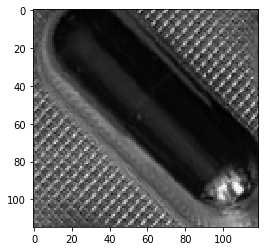

In [106]:
plt.imshow(query, 'gray')

In [99]:
k = 10
len_points = []
boxes = []

query = query[padd:-padd, padd:-padd]
query_shape = query.shape
gallery_shape = gallery.shape

step_1 = query_shape[0] // k
step_2 = query_shape[1] // k

for i in range(0, gallery_shape[0] - query_shape[0], step_1):
    for j in range(0 , gallery_shape[1] - query_shape[1], step_2):
        im = gallery[i : query_shape[0] + i, j : query_shape[1] + j]   
        try:

            sift = cv2.xfeatures2d.SIFT_create()

            kp1, des1 = sift.detectAndCompute(query,None)
            kp2, des2 = sift.detectAndCompute(im,None)

            index_params = dict(algorithm = 1, trees = 5)
            flann = cv2.FlannBasedMatcher(index_params)
            matches = flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)

            good = [m for m,n in matches if m.distance < 0.7 * n.distance]

            src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

            len_points.append(len(dst_pts))
            boxes.append([i, j, i + query_shape[0], j + query_shape[1]])

        except Exception:
            continue

True

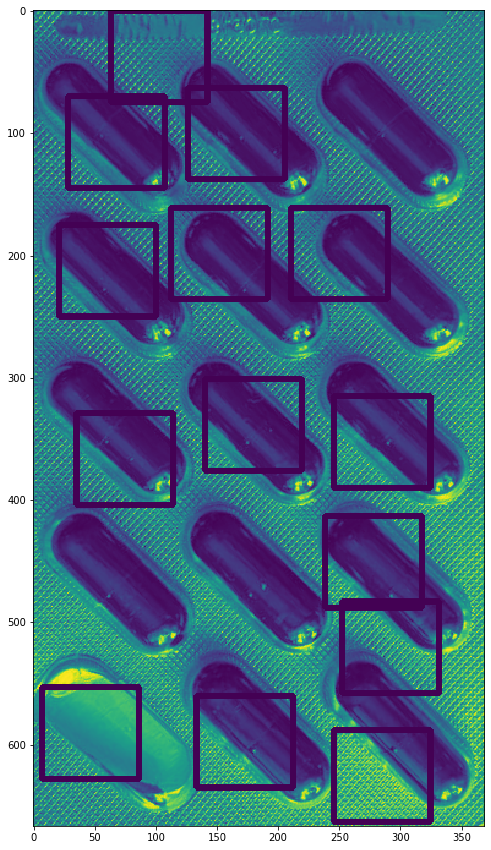

In [101]:
len_points = np.array(len_points)
boxes = np.array(boxes)
res = []
if len(boxes) > 0:
    final_boxes = filter_boxes(boxes[len_points > 5], len_points[len_points > 5], 0.05)
    
img3 = gallery.copy()
for box in final_boxes:
    img3 = cv2.rectangle(img3, (box[1] , box[0]) , (box[3], box[2]) ,(0, 255, 0), 3)
plt.figure(figsize = (15,15))
plt.imshow(img3)
cv2.imwrite('res.png', img3)